In [1]:
import sys
import shutil
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import *
from plot_skylocs import LimitPlot
from astropy.cosmology import Planck15
import corner
import healpy as hp
from NPTFit import create_mask as cm

%matplotlib inline
%load_ext autoreload
%autoreload 2

catalog = pd.read_csv("/tigress/nrodd/DM-Catalog-Scan/DataFiles/Catalogs/2MRSLocalTully_ALL_DATAPAPER_Planck15_v7.csv")

/tigress/smsharma/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
from local_dirs import *

In [4]:
sys.path.append(work_dir + '/Smooth-Maps')
sys.path.append(work_dir + '/Make-DM-Maps')
import king_smooth as ks

In [5]:
from local_dirs import *
sys.path.append(nptf_old_dir)
import fermi.fermi_plugin as fp

In [6]:
f_global = fp.fermi_plugin(maps_dir,fermi_data_dir=fermi_data_dir,work_dir=work_dir,CTB_en_min=0,CTB_en_max=40,nside=512,eventclass=5,eventtype=0,newstyle=1,data_July16=True)

In [7]:
passed_halos = np.load("included_halos.npy")

In [8]:
catalog['zred'] = catalog['z']*1000
catalog['log10cvir_inf'] = np.log10(catalog['cvir_inf'])
catalog['theta_s'] = catalog['ang_ext']/2.
catalog['bsh'] = 10**catalog['mulog10J_inf']/10**catalog['mulog10Jnb_inf'] - 1
catalog['paperName'] = [catalog['GName'][i] if isinstance(catalog['GName'][i], str) else catalog['Name'][i] for i in range(len(catalog))]

In [9]:
source_3fg_df = pd.read_csv('../../DataFiles/Catalogs//3fgl.dat', sep='|', comment='#')
# Remove whitespace from column names
source_3fg_df.rename(columns=lambda x: x.strip(), inplace=True)
for col in source_3fg_df.columns.values:
    try:
        source_3fg_df[col] = source_3fg_df[
            col].map(str.strip)
    except TypeError:
        continue

# Convert to numeric data
source_3fg_df = source_3fg_df.convert_objects(
    convert_numeric=True)


/tigress/smsharma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  del sys.path[0]


In [15]:
example4a = ~cm.make_mask_total(mask_ring = True, inner = 0, outer = 15, ring_b = 10, ring_l = 10, nside=512)

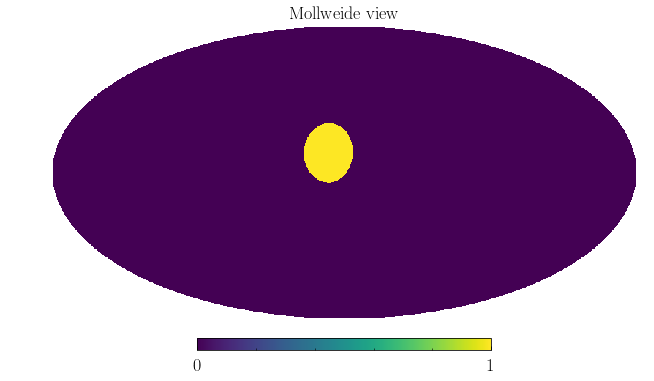

In [16]:
hp.mollview(example4a)

In [17]:
ksi = ks.king_smooth(maps_dir, 10, 5, 0, threads=1)

In [ ]:
maps_ary = []

for idx, ihalo in enumerate(tqdm_notebook(passed_halos[:10])):
    
    the_map = np.sum(f_global.CTB_count_maps[4:],axis=0)

    
    l = catalog.l.values[ihalo]  
    b = catalog.b.values[ihalo]  
    
    mask = ~cm.make_mask_total(mask_ring = True, inner = 0, outer = 15, ring_b = b, ring_l = l, nside=512)

    maps_ary.append(ksi.smooth_the_map(np.float64(the_map*mask)))

In [84]:
int(40000*10*catalog['ang_ext'][ihalo]/2.)

122022.71406999999

/tigress/smsharma/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


ValueError: max() arg is an empty sequence

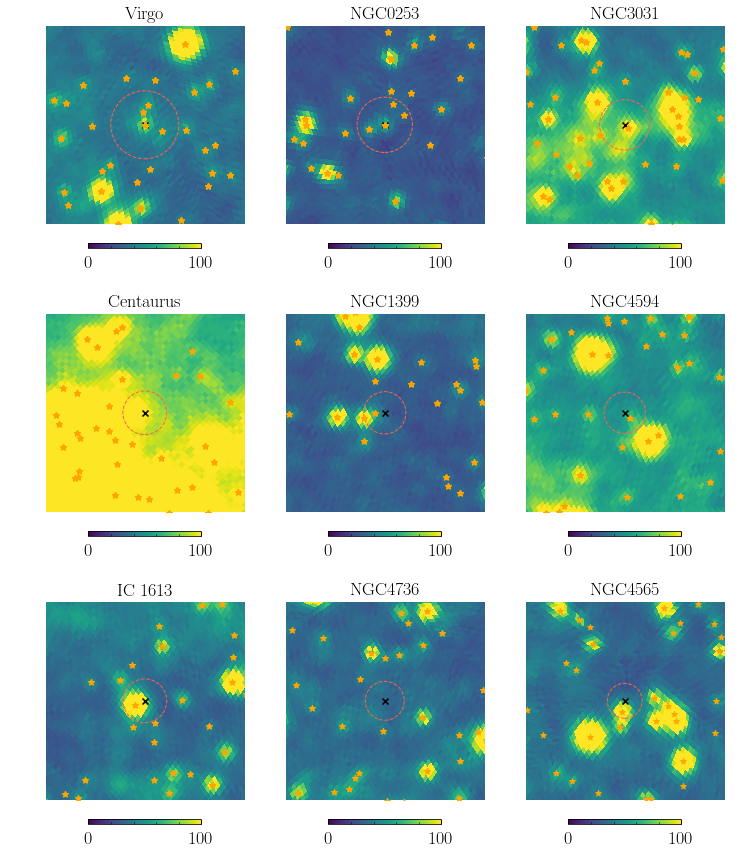

In [94]:
oFig1 = plt.figure(1,figsize=(10,16))

lbrange = 10   

for idx, ihalo in enumerate(tqdm_notebook(passed_halos[:9])):
    
    the_map = np.sum(f_global.CTB_count_maps[4:],axis=0)

    
    l = catalog.l.values[ihalo]  
    b = catalog.b.values[ihalo]  
    
    mask = ~cm.make_mask_total(mask_ring = True, inner = 0, outer = 15, ring_b = b, ring_l = l)

    hp.cartview(maps_ary[idx], min = 0, max = 100, rot=(l,b), lonra=[-lbrange,lbrange],latra=[-lbrange,lbrange], title=catalog['paperName'].values[ihalo].replace("_", " "),sub=(4,3,idx+1))


    hp.projscatter(l, b, lonlat=True, coord='G', marker='x', color='k')

    hp.projscatter(l, b, lonlat=True, coord='G', marker='o', s = int(40000/10*catalog['ang_ext'][ihalo]/2.), color='k', facecolors='none', edgecolors='tomato', linestyle = '--')



    l = source_3fg_df['_Lii']
    b = source_3fg_df['_Bii']

    hp.projscatter(l, b, lonlat=True, coord='G', marker='*', color='orange')

plt.tight_layout()
plt.savefig("../plots/skymaps.pdf")